In [1]:
import sys
# !{sys.executable} -m pip install --upgrade h5py numpy scipy matplotlib seaborn plumbum
#######################################################
#Import packages
import numpy as np
import os
import re
from math import sin, cos, pi
import glob
import subprocess
import pickle
from subprocess import call, check_output
import pandas as pd
# import psi4

from time import time
import matplotlib.pyplot as plt
from plumbum.cmd import grep, awk

import shutil
import random
import sklearn
from shutil import copy
import csv
import h5py as h5
import seaborn as sns; sns.set(style="ticks", color_codes=True)

from sklearn.model_selection import train_test_split

In [2]:
#######################################################
# Obital labels
## Inactive i,j
## Active t,u,v
## Virtual a,b

## Type 1: IA->AA
## Type 2: II->AA (P)
## Type 3: II->AA (M)
## Type 4: AA->VA
## Type 5: IA->VA/AV
## Type 6: II->AV (P)
## Type 7: II->AV (M)
## Type 8: AA->VV (P)
## Type 9: AA->VV (M)
## Type 10: IA->VV (P)
## Type 11: IA->VV (M)
## Type 12: II->VV (P)
## Type 13: II->VV (M)

## A: IA->AA
## B: II->AA
## C: AA->VA
## D: IA->VA/AV
## E: II->AV
## F: AA->VV
## G: IA->VV 
## H: II->VV
#######################################################


In [3]:
# Set precision, we can change this at will
np.set_printoptions(precision=4)
# pd.set_option('precision', 4)

# This tells us the number of structures and how theyre labeled
# structs=np.arange(106,181,0.5)
structs=np.arange(106,181,10)
# CASPT2 excitation types
excittype=np.arange(1,14,1)
# Define molecule
typ='O3'

# Find structures
struct_name=[i for i in os.listdir() if i.endswith('.xyz') and i.startswith(f'{typ}') and '_' in i]

if len(struct_name)==0:
    for i in structs:
        if os.path.exists(os.path.join(os.getcwd(),'Coords',f'O3_{i}.xyz')):
            struct_name.append(f'O3_{i}.xyz')


In [4]:
print(len(structs))
with open('keys.pickle', 'wb') as handle:
    pickle.dump([str(i) for i in structs], handle, protocol=pickle.HIGHEST_PROTOCOL)
    
l=[str(i) for i in structs]
l=[i for i in l if float(i)>=110.0 and float(i)<=170.0]
print(len(l))
# train_ind,test_ind=train_test_split(l, test_size=0.3, random_state=0)
# print(len(train_ind),len(test_ind))
# with open('train_ind.pickle', 'wb') as handle:
#     pickle.dump(train_ind, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open('test_ind.pickle', 'wb') as handle:
#     pickle.dump(test_ind, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('test_ind.pickle', 'rb') as handle:
    test_ind = pickle.load(handle)

with open('train_ind.pickle', 'rb') as handle:
    train_ind = pickle.load(handle)
    
print(len(train_ind),len(test_ind))    
structs=l
print(len(structs))

8
6
4 2
6


In [5]:
# Delete excessive extra files
def del_useless():
    '''
    Delete the extra files
    '''
    for i in os.listdir():
        for j in ['status','GssOrb','LprOrb','LoProp','guessorb','xmldump','RasOrb','SpdOrb']:
            if j in i:
                os.remove(i)

In [6]:
# When restarting a setr of calculations just clear everyting out
def clean_dir():
    for entry in os.scandir(path=os.getcwd()):
        if entry.is_dir():
            if entry.name=='Fock':
                shutil.rmtree(entry.name)
            if entry.name=='hdf5':
                shutil.rmtree(entry.name)
            if entry.name=='e2':
                shutil.rmtree(entry.name)                
            if entry.name=='Labels':
                shutil.rmtree(entry.name)
            if entry.name=='Coords':
                shutil.rmtree(entry.name)
            if 'dir' in entry.name:
                shutil.rmtree(entry.name)
                


In [7]:
# Run this before clean_dir, this pulls the xyz files out just to 
def pull_xyz():
    import re
    for i in struct_name:
        if os.path.exists(os.path.join(os.getcwd(),i))==False and os.path.exists(os.path.join(os.getcwd(),'Coords')):
            shutil.copy(os.path.join(os.getcwd(),'/'.join(('Coords',i))),os.path.join(os.getcwd(),i))


In [8]:
basis_set='ANO-RCC-MB'

In [9]:
def gen_gateway(angle):
    string=f'''&GATEWAY 
coord={f'O3_{angle}.xyz'}
Basis = {basis_set}
Group = nosymm
End of Input


'''
    return string
def gen_seward():
    string=f'''&SEWARD
End of Input
'''
    return string

def gen_motra(angle):
    string=f'''&MOTRA
Frozen=0
>>> COPY $WorkDir/GMJ_one_int_indx.csv $CurrDir/{angle}.GMJ_one_int_indx.csv
>>> COPY $WorkDir/GMJ_one_int.csv $CurrDir/{angle}.GMJ_one_int.csv
>>> COPY $WorkDir/GMJ_two_int_indx.csv $CurrDir/{angle}.GMJ_two_int_indx.csv
>>> COPY $WorkDir/GMJ_two_int.csv $CurrDir/{angle}.GMJ_two_int.csv

'''
    return string

def gen_scf(angle):
    string=f"""&SCF &END
>>> COPY $WorkDir/PT2_ozone_{angle}.scf.h5 $CurrDir/
"""
    return string    


def gen_rasscf(angle):
    string=f"""&RASSCF &END
Title= RASSCF
fileorb
{fileorb}
NACTEL
4 0 0
Inactive
10
RAS2
3
Symmetry
1
Spin
1
orblisting
all
ITERation
200 100
CIMX
200
SDAV
500
PRWF
0
PRSD
>>> COPY $WorkDir/PT2_ozone_{angle}.rasscf.h5 $CurrDir/
>>> COPY $WorkDir/GMJ_Fock_MO.csv $CurrDir/{angle}.GMJ_Fock_MO.csv
"""
    return string    

def gen_caspt2():
    string="""&CASPT2 &END
Frozen 
0
Imaginary Shift
0.0

>>foreach i in (B,E,F,G,H)
>>foreach j in (P,M)
>>if ( -FILE GMJ_e2_${i}_${j}.csv )
>>> COPY $WorkDir/GMJ_RHS_${i}_${j}.csv $CurrDir/GMJ_RHS_${i}_${j}.csv
>>> COPY $WorkDir/GMJ_IVECW_${i}_${j}.csv $CurrDir/GMJ_IVECW_${i}_${j}.csv
>>> COPY $WorkDir/GMJ_e2_${i}_${j}.csv $CurrDir/GMJ_e2_${i}_${j}.csv
>>endif
>>enddo
>>enddo

>>foreach i in (A,C,D)
>>if ( -FILE GMJ_e2_$i.csv )
>>> COPY $WorkDir/GMJ_RHS_$i.csv $CurrDir/GMJ_RHS_$i.csv
>>> COPY $WorkDir/GMJ_IVECW_$i.csv $CurrDir/GMJ_IVECW_$i.csv
>>> COPY $WorkDir/GMJ_e2_$i.csv $CurrDir/GMJ_e2_$i.csv
>>endif
>>enddo

"""
    return string    





In [10]:
def gen_XYZ(angle):
    f=open(f'O3_{angle}.xyz','w+')
#     radius=1.472
    radius=1.278
    O1=f'O {radius*cos(((angle/2)*(pi/180))):.6f} {radius*sin((angle/2)*(pi/180)):.6f} {0.0000:.6f}'
    O2=f'O {0.0000:.6f} {0.0000:.6f} {0.0000:.6f}'
    O3=f'O {radius*cos(-(angle/2)*(pi/180)):.6f} {radius*sin(-(angle/2)*(pi/180)):.6f} {0.0000:.6f}'
    mylist=[O1, O2, O3]
    f.write(str(len(mylist))+'\n'+'\n')
    [f.write(i+'\n') for i in mylist]
    f.close()
    return mylist
    

def gen_eq_orbs():
    angle=118
    gen_XYZ(angle)
    new_input=f'''&GATEWAY 
coord={f'O3_{angle}.xyz'}
Basis = {basis_set}
Group = nosymm
End of Input



&SEWARD
End of Input

&RASSCF &END
Title= RASSCF
NACTEL
4 0 0
Inactive
10
RAS2
3
Symmetry
1
Spin
1
ALTEr=2; 1 7 11; 1 10 12;
orblisting
all
ITERation
200 100
CIMX
200
SDAV
500
PRWF
0
PRSD

&CASPT2 &END
Frozen
0
Imaginary Shift
0.0
'''
    g=open(f'eq_orbs.input', 'wb')
    g.write(new_input.encode())
    g.close()
    call(['pymolcas', f'eq_orbs.input', '-oe', f'eq_orbs.output'])

# ALTEr=3; 1 10 11; 1 9 12; 1 13 13

fileorb=os.path.join(os.getcwd(),'eq_orbs.RasOrb')

def Gen_Scan():
    import re
    for angle in structs:
        gen_XYZ(int(angle))
        g=open(f'PT2_ozone_{angle}.input', 'wb')
        g.write(gen_gateway(angle).encode())
        g.write(gen_seward().encode())
        g.write(gen_motra(angle).encode())
        g.write(gen_scf(angle).encode())        
        g.write(gen_rasscf(angle).encode())        
        g.write(gen_caspt2().encode())
        g.close()
        call(['pymolcas','-new','-clean',f'PT2_ozone_{angle}.input', '-oe', f'PT2_ozone_{angle}.output'])
        [shutil.move(os.path.join(os.getcwd(),i),os.path.join(os.getcwd(),f'{angle}.{i}')) for i in glob.glob(f'GMJ_RHS_*')]
        [shutil.move(os.path.join(os.getcwd(),i),os.path.join(os.getcwd(),f'{angle}.{i}')) for i in glob.glob(f'GMJ_IVECW_*')]        
        [shutil.move(os.path.join(os.getcwd(),i),os.path.join(os.getcwd(),f'{angle}.{i}')) for i in glob.glob(f'GMJ_e2_*')]

In [11]:
# Move input and output files to their proper directory
def mv_fils():
    '''
    Move the files to directories named for them
    '''
    import shutil
    import os
    for i in structs:
        if os.path.exists(os.path.join(os.getcwd(),f'{i}_dir')) is True:
            if os.path.exists(os.path.join(os.getcwd(),f'PT2_ozone_{i}.output'))==True:
                shutil.move(os.path.join(os.getcwd(),f'PT2_ozone_{i}.output'),os.path.join(os.getcwd(),f'{i}_dir',f'PT2_ozone_{i}.output'))
            if os.path.exists(os.path.join(os.getcwd(),f'PT2_ozone_{i}.input'))==True:
                shutil.move(os.path.join(os.getcwd(),f'PT2_ozone_{i}.input'),os.path.join(os.getcwd(),f'{i}_dir',f'PT2_ozone_{i}.input'))
        else:
            os.mkdir(f'{i}_dir')
            if os.path.exists(os.path.join(os.getcwd(),f'PT2_ozone_{i}.output'))==True:
                shutil.move(os.path.join(os.getcwd(),f'PT2_ozone_{i}.output'),os.path.join(os.getcwd(),f'{i}_dir',f'PT2_ozone_{i}.output'))
            if os.path.exists(os.path.join(os.getcwd(),f'PT2_ozone_{i}.input'))==True:
                shutil.move(os.path.join(os.getcwd(),f'PT2_ozone_{i}.input'),os.path.join(os.getcwd(),f'{i}_dir',f'PT2_ozone_{i}.input'))




In [12]:
# Move data files to directories
def mv_dat():
# Move h5 and coord files to dirs
    for i in os.listdir():
        if i.endswith('h5'):
            if os.path.exists(os.path.join(os.getcwd(),i))==True:
                if os.path.exists(os.path.join(os.getcwd(),f'hdf5')) is True:
                    shutil.move(os.path.join(os.getcwd(),i),os.path.join(os.getcwd(),'/'.join(('hdf5',i))))
                else:
                    os.mkdir(f'hdf5')
                    shutil.move(os.path.join(os.getcwd(),i),os.path.join(os.getcwd(),'/'.join(('hdf5',i))))
# Move xyz files
        if i.endswith('.xyz') and i.startswith(f'{typ}') and '_' in i:
            if os.path.exists(os.path.join(os.getcwd(),i))==True:
                if os.path.exists(os.path.join(os.getcwd(),f'Coords')) is True:
                    shutil.move(os.path.join(os.getcwd(),i),os.path.join(os.getcwd(),'/'.join(('Coords',i))))
                else:
                    os.mkdir(f'Coords')
                    shutil.move(os.path.join(os.getcwd(),i),os.path.join(os.getcwd(),'/'.join(('Coords',i))))
# Move pair energy files
        if '_e2' in i and i.endswith('csv'):
            if os.path.exists(os.path.join(os.getcwd(),i))==True:
                if os.path.exists(os.path.join(os.getcwd(),f'e2')) is True:
                    shutil.move(os.path.join(os.getcwd(),i),os.path.join(os.getcwd(),'/'.join(('e2',i))))
                else:
                    os.mkdir(f'e2')
                    shutil.move(os.path.join(os.getcwd(),i),os.path.join(os.getcwd(),'/'.join(('e2',i))))
# Move rhs files which tell how the ivvecc2 and ivecw files are indexed
        if 'RHS' in i and i.endswith('csv'):
            if os.path.exists(os.path.join(os.getcwd(),i))==True:
                if os.path.exists(os.path.join(os.getcwd(),f'Labels')) is True:
                    shutil.move(os.path.join(os.getcwd(),i),os.path.join(os.getcwd(),'/'.join(('Labels',i))))
                else:
                    os.mkdir(f'Labels')
                    shutil.move(os.path.join(os.getcwd(),i),os.path.join(os.getcwd(),'/'.join(('Labels',i))))
        if 'IVECW' in i and i.endswith('csv'):
            if os.path.exists(os.path.join(os.getcwd(),i))==True:
                if os.path.exists(os.path.join(os.getcwd(),f'IVECW')) is True:
                    shutil.move(os.path.join(os.getcwd(),i),os.path.join(os.getcwd(),'/'.join(('IVECW',i))))
                else:
                    os.mkdir(f'IVECW')
                    shutil.move(os.path.join(os.getcwd(),i),os.path.join(os.getcwd(),'/'.join(('IVECW',i))))

                    
# MO fock matrix
        if 'Fock' in i and i.endswith('csv'):
            if os.path.exists(os.path.join(os.getcwd(),i))==True:
                if os.path.exists(os.path.join(os.getcwd(),f'Fock')) is True:
                    shutil.move(os.path.join(os.getcwd(),i),os.path.join(os.getcwd(),'/'.join(('Fock',i))))
                else:
                    os.mkdir(f'Fock')
                    shutil.move(os.path.join(os.getcwd(),i),os.path.join(os.getcwd(),'/'.join(('Fock',i))))
        if i.endswith('_one_int_indx.csv'):
            if os.path.exists(os.path.join(os.getcwd(),i))==True:
                if os.path.exists(os.path.join(os.getcwd(),f'1_int_idx')) is True:
                    shutil.move(os.path.join(os.getcwd(),i),os.path.join(os.getcwd(),'/'.join(('1_int_idx',i))))
                else:
                    os.mkdir(f'1_int_idx')
                    shutil.move(os.path.join(os.getcwd(),i),os.path.join(os.getcwd(),'/'.join(('1_int_idx',i))))
        if i.endswith('_two_int_indx.csv'):
            if os.path.exists(os.path.join(os.getcwd(),i))==True:
                if os.path.exists(os.path.join(os.getcwd(),f'2_int_idx')) is True:
                    shutil.move(os.path.join(os.getcwd(),i),os.path.join(os.getcwd(),'/'.join(('2_int_idx',i))))
                else:
                    os.mkdir(f'2_int_idx')
                    shutil.move(os.path.join(os.getcwd(),i),os.path.join(os.getcwd(),'/'.join(('2_int_idx',i))))
        if i.endswith('GMJ_one_int.csv'):
            if os.path.exists(os.path.join(os.getcwd(),i))==True:
                if os.path.exists(os.path.join(os.getcwd(),f'1_ints')) is True:
                    shutil.move(os.path.join(os.getcwd(),i),os.path.join(os.getcwd(),'/'.join(('1_ints',i))))
                else:
                    os.mkdir(f'1_ints')
                    shutil.move(os.path.join(os.getcwd(),i),os.path.join(os.getcwd(),'/'.join(('1_ints',i))))
        if i.endswith('GMJ_two_int.csv'):
            if os.path.exists(os.path.join(os.getcwd(),i))==True:
                if os.path.exists(os.path.join(os.getcwd(),f'2_ints')) is True:
                    shutil.move(os.path.join(os.getcwd(),i),os.path.join(os.getcwd(),'/'.join(('2_ints',i))))
                else:
                    os.mkdir(f'2_ints')
                    shutil.move(os.path.join(os.getcwd(),i),os.path.join(os.getcwd(),'/'.join(('2_ints',i))))
#         if i.endswith('GMJ_AO_INT.csv'):
#             if os.path.exists(os.path.join(os.getcwd(),i))==True:
#                 if os.path.exists(os.path.join(os.getcwd(),f'AO_ints')) is True:
#                     shutil.move(os.path.join(os.getcwd(),i),os.path.join(os.getcwd(),'/'.join(('AO_ints',i))))
#                 else:
#                     os.mkdir(f'AO_ints')
#                     shutil.move(os.path.join(os.getcwd(),i),os.path.join(os.getcwd(),'/'.join(('AO_ints',i))))





In [13]:


def run():
    # Pull xyz structures
    pull_xyz()
    # The rest follows as labeled above
    clean_dir()
    gen_eq_orbs()    
    Gen_Scan() 
    mv_fils()
    del_useless()
    mv_dat()

In [20]:
del_useless()

In [21]:
# Do a new run
run()

In [14]:
# Grab caspt2 energies
def caspt2():
    PT2=[]
    PT2List=[]
    PT2labels=[]

    for j in structs:
        if os.path.exists(os.path.join(os.getcwd(),f'{j}_dir'))==True:
            path=os.path.join(os.getcwd(),f'{j}_dir',f'PT2_ozone_{j}.output')
            PT2labels.append(j)
            PT2.append(float((grep['-i', '::    CASPT2',path] | awk['{print $NF }'])()))
    PT2List=np.array(PT2)
    PT2Dict=pd.DataFrame({'Label':PT2labels,'PT2':PT2List})
    PT2Dict.to_csv('CASPT2.csv')        
    return PT2Dict.set_index('Label')

In [15]:
df_CASPT2=caspt2()

In [16]:
# How to grab the whole row
# caspt2().loc[caspt2()['Labels'] =='ethylene_7']

In [17]:
# Grab casscf energies 
def casscf():
    SCF=[]
    SCFList=[]
    SCFlabels=[]
    for j in structs:
        if os.path.exists(os.path.join(os.getcwd(),f'{j}_dir'))==True:
            path=os.path.join(os.getcwd(),f'{j}_dir',f'PT2_ozone_{j}.output')
            SCFlabels.append(j)
            SCF.append(float((grep['-i', '::    RASSCF root number  1',path] | awk['{print $8 }'])()))
    SCFList=np.array(SCF)
    SCFDict=pd.DataFrame({'Label':SCFlabels,'SCF':SCFList})
    SCFDict.to_csv('CASSCF.csv')    
    return SCFDict.set_index('Label')

In [18]:
df_CASSCF=casscf()


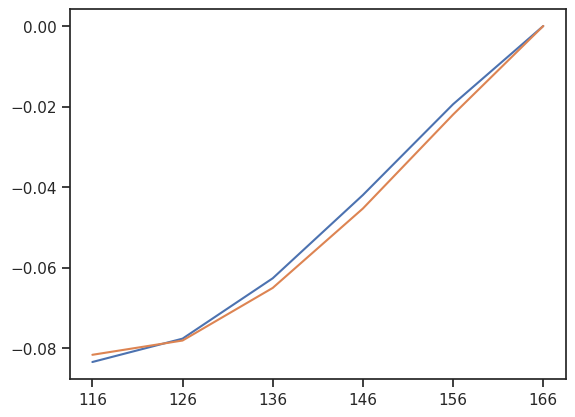

In [19]:

plt.plot(df_CASSCF-df_CASSCF.max())
plt.plot(df_CASPT2-df_CASPT2.max())
plt.show()

In [20]:
# Grab PT2 energies 
def PT2():
    E2=[]
    E2List=[]
    E2labels=[]
    ES_E2=[]
    ES_E2List=[]
    ES_E2labels=[]

    for j in structs:
        if os.path.exists(os.path.join(os.getcwd(),f'{j}_dir'))==True:
            path=os.path.join(os.getcwd(),f'{j}_dir',f'PT2_ozone_{j}.output')
            E2labels.append(j)
            E2.append(float((grep['-i', 'E2 (Variational):',path] | awk['{print $NF }'])()))
    E2List=np.array(E2)
    E2Dict=pd.DataFrame({'Label':E2labels,'E2':E2List})
    df=E2Dict.set_index('Label')
    df.to_csv('E2.csv')
    return df

In [21]:
E2Dict=PT2()

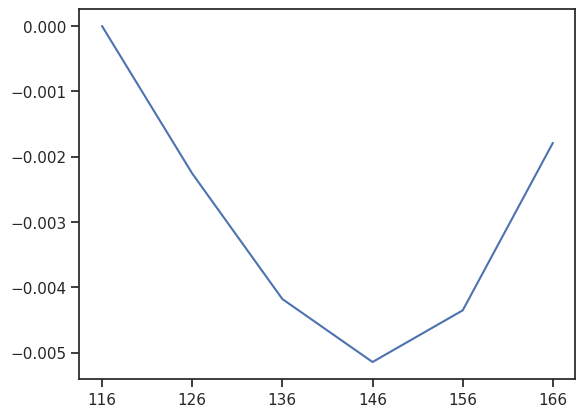

In [22]:

plt.plot(E2Dict-E2Dict.max())
plt.show()

In [23]:
# Grab file paths for the directories
# onlyfiles = [f for f in os.listdir(os.getcwd()) if os.path.isdir(os.path.join(os.getcwd(), f))]
onlyfiles = (f for f in os.listdir(os.getcwd()) if os.path.isdir(os.path.join(os.getcwd(), f)))
for entry in os.scandir(path=os.getcwd()):
    if entry.is_dir():
        if entry.name=='Fock':
            path_to_Focks=os.path.join(os.getcwd(),entry.name)
        if entry.name=='e2':
            path_to_e2=os.path.join(os.getcwd(),entry.name)
        if entry.name=='Labels':
            path_to_Labels=os.path.join(os.getcwd(),entry.name)
        if entry.name=='IVECW':
            path_to_IVECW=os.path.join(os.getcwd(),entry.name)
        if entry.name=='1_ints':
            path_to_1_ints=os.path.join(os.getcwd(),entry.name)
        if entry.name=='2_ints':
            path_to_2_ints=os.path.join(os.getcwd(),entry.name)
        if entry.name=='1_int_idx':
            path_to_1_int_idx=os.path.join(os.getcwd(),entry.name)
        if entry.name=='2_int_idx':
            path_to_2_int_idx=os.path.join(os.getcwd(),entry.name)


In [24]:

typ_exists=sorted(sum(list([j.replace('GMJ_e2_','') for j in i.split('/')[-1].split('.') if 'GMJ' in j] for i in glob.glob(os.path.join(path_to_e2,f'{structs[0]}.GMJ_e2_*'))),[]))


In [25]:
typ_exists

['A', 'B_P', 'C', 'D', 'E_M', 'E_P', 'F_M', 'F_P', 'G_M', 'G_P', 'H_M', 'H_P']

In [26]:
with open('exists.pickle', 'wb') as handle:
    pickle.dump(typ_exists, handle, protocol=pickle.HIGHEST_PROTOCOL)



In [27]:
cwd = os.getcwd()
#   Keep everything at float64
DTYPE = np.float_
# DTYPE = np.float16

#   Create an array with the easy data
def createArrray(filename):
    files = sorted(glob.glob(filename))
    arrayname = []
    for i in sorted(files):
        arrayname.append(
            np.stack(
                np.array(pd.read_csv(i, header=None),
                         dtype=DTYPE,
                         copy=False).flatten()))

    arrayname = np.asarray(arrayname, dtype=DTYPE)
    return arrayname
#   Start transforming the HDF5 files from the data directory
h5list = []
for i in structs:
    h5list.append(os.path.join(os.getcwd(),'hdf5',f'PT2_ozone_{str(i)}.rasscf.h5'))
# Grab AO_OVERLAP_MATRIX,MO_ENERGIES,MO_OCCUPATIONS,MO_VECTORS,MO_TYPEINDICES,NACTEL,NBAS from hdf5
def h5feats(h5list):
    f = h5.File(h5list[0], 'r')
    datasetNames = [n for n in f.keys()]
    b = []
    labels = []
    # AO_FOCKINT_MATRIX=[]
    # Useful attributes from the hdf5 files
    NBAS=[]
    NACTEL=[]
    for k, elem in enumerate(structs):
        for count, ele in enumerate([i for i in f.attrs]):
            if ele =='NBAS':
                for i, elemt in enumerate(np.array(h5.File(h5list[k],'r').attrs[ele]).reshape(-1)):
                    NBAS.append(elemt)
            if ele =='NACTEL':
                for i, elemt in enumerate(np.array(h5.File(h5list[k],'r').attrs[ele]).reshape(-1)):
                    NACTEL.append(elemt)


    MO_ENERGIES=[]
    MO_OCCUPATIONS=[]
    MO_TYPEINDICES=[]
    MO_VECTORS=[]
    t0=time()
    #   Eliminate certain features that won't be good for regression
    for k, elem in enumerate(structs):
        for count, ele in enumerate([n for n in h5.File(h5list[k], 'r').keys()]):
            if ele =='MO_TYPEINDICES':
                for i, elemt in enumerate(np.array(h5.File(h5list[k],'r')[ele]).reshape(-1)):
                    MO_TYPEINDICES.append(elemt)

            if ele =='MO_ENERGIES':
                for i, elemt in enumerate(np.array(h5.File(h5list[k],'r')[ele]).reshape(-1)):
                    MO_ENERGIES.append(elemt)

            if ele =='MO_OCCUPATIONS':
                for i, elemt in enumerate(np.array(h5.File(h5list[k],'r')[ele]).reshape(-1)):
                    MO_OCCUPATIONS.append(elemt)


                    

    print(f'time: {time()-t0} s')
    # AO_FOCKINT_MATRIX=np.array(AO_FOCKINT_MATRIX).reshape(len(dislist),int(NBAS[0]),int(NBAS[0]))
    MO_ENERGIES= np.array(MO_ENERGIES).reshape(len(structs),int(NBAS[0]))
    MO_OCCUPATIONS= np.array(MO_OCCUPATIONS).reshape(len(structs),int(NBAS[0]))
    MO_TYPEINDICES=np.array(MO_TYPEINDICES).reshape(len(structs),int(NBAS[0]))
    
    return MO_OCCUPATIONS,MO_TYPEINDICES,NACTEL,NBAS


MO_OCCUPATIONS,MO_TYPEINDICES,NACTEL,NBAS=h5feats(h5list)


h5list_scf = []
for i in structs:
    h5list_scf.append(os.path.join(os.getcwd(),'hdf5',f'PT2_ozone_{str(i)}.scf.h5'))
# Grab AO_OVERLAP_MATRIX,MO_ENERGIES,MO_OCCUPATIONS,MO_VECTORS,MO_TYPEINDICES,NACTEL,NBAS from hdf5
def MO_VEC(h5list_scf):
    f = h5.File(h5list_scf[0], 'r')
    datasetNames = [n for n in f.keys()]
    b = []
    labels = []
    # AO_FOCKINT_MATRIX=[]
    # Useful attributes from the hdf5 files
    NBAS=[]
    NACTEL=[]
    for k, elem in enumerate(structs):
        for count, ele in enumerate([i for i in f.attrs]):
            if ele =='NBAS':
                for i, elemt in enumerate(np.array(h5.File(h5list_scf[k],'r').attrs[ele]).reshape(-1)):
                    NBAS.append(elemt)
    MO_VECTORS=[]
    MO_ENERGIES=[]  
    MO_OCCUPATIONS=[]
    t0=time()
    #   Eliminate certain features that won't be good for regression
    for k, elem in enumerate(structs):
        for count, ele in enumerate([n for n in h5.File(h5list_scf[k], 'r').keys()]):
            if ele =='MO_VECTORS':
                for i, elemt in enumerate(np.array(h5.File(h5list_scf[k],'r')[ele]).reshape(-1)):
                    MO_VECTORS.append(elemt)
            if ele =='MO_ENERGIES':
                for i, elemt in enumerate(np.array(h5.File(h5list_scf[k],'r')[ele]).reshape(-1)):
                    MO_ENERGIES.append(elemt)
            if ele =='MO_OCCUPATIONS':
                for i, elemt in enumerate(np.array(h5.File(h5list_scf[k],'r')[ele]).reshape(-1)):
                    MO_OCCUPATIONS.append(elemt)

                    

                    

                    

    print(f'time: {time()-t0} s')
    MO_ENERGIES= np.array(MO_ENERGIES).reshape(len(structs),int(NBAS[0]))
    MO_OCCUPATIONS= np.array(MO_OCCUPATIONS).reshape(len(structs),int(NBAS[0]))
    MO_VECTORS=np.array(MO_VECTORS).reshape(len(structs),int(NBAS[0]),int(NBAS[0]))
    
    return MO_VECTORS,MO_ENERGIES,MO_OCCUPATIONS


MO_VECTORS,scf_F,scf_OCC=MO_VEC(h5list_scf)



time: 0.006539106369018555 s
time: 0.00615239143371582 s


In [28]:
def gen_indx(list_of_dicts):
    indx=[]
    for i in list_of_dicts.keys():
        if len(list_of_dicts[i])>0:
            indx.append(list(list_of_dicts[i].keys()))
    return indx[0]


path_check=os.path.join(os.getcwd(),f'{structs[0]}_dir',f'PT2_ozone_{structs[0]}.output')

# Sanity check...
# REMEVDZPER FROZEN CORE APPROXIMATION
# Number of frozen orbitals
fro=int(subprocess.Popen(f"grep -i 'Frozen orbitals' {path_check} | tail -n 1",shell=True,stdout=subprocess.PIPE,stderr=subprocess.STDOUT).communicate()[0].split()[-1])
# Number of inactive orbitals
inact=int(subprocess.Popen(f"grep -i 'Inactive orbitals' {path_check} | tail -n 1",shell=True,stdout=subprocess.PIPE,stderr=subprocess.STDOUT).communicate()[0].split()[-1])
# Number of active orbitals
act=int(subprocess.Popen(f"grep -i 'Active orbitals' {path_check} | tail -n 1",shell=True,stdout=subprocess.PIPE,stderr=subprocess.STDOUT).communicate()[0].split()[-1])
# Number of seconary orbitals
virt=int(subprocess.Popen(f"grep -i 'Secondary orbitals' {path_check} | tail -n 1",shell=True,stdout=subprocess.PIPE,stderr=subprocess.STDOUT).communicate()[0].split()[-1])
# Number of basis functions for sanity check
bas_check=int(subprocess.Popen(f"grep -i 'Number of basis functions' {path_check} | tail -n 1",shell=True,stdout=subprocess.PIPE,stderr=subprocess.STDOUT).communicate()[0].split()[-1])

Basis_Indices=[]
for i in range(fro):
    Basis_Indices.append(f'F{i+1}')
for i in range(inact):
    Basis_Indices.append(f'I{i+1}')
for i in range(act):
    Basis_Indices.append(f'A{i+1}')
for i in range(virt):
    Basis_Indices.append(f'S{i+1}')    
    
print(f'Basis sanity check passed={bas_check==len(Basis_Indices)}') 

Basis sanity check passed=True


In [29]:
# Generate the labels that match the IVECW and IVECC2 files
def gen_labels(typ):
    Labels=[]
    Indexes=[]
    i=structs[0]
    return [j.split()[0].replace('\n','').replace('00','').replace('S0','S').replace('I0','I').replace(',','') for j in open(os.path.join(path_to_Labels,f'{i}.GMJ_RHS_{typ}.csv'),'r').readlines()]




In [30]:
def gen_pair_labels(typ):
    Labels=[]
    Indexes=[]
    i=structs[0]
    return sorted(set(['_'.join(j.split()[0].replace('\n','').replace('00','').replace('S0','S').replace('I0','I').replace(',','').split('_')[0:2]) for j in open(os.path.join(path_to_Labels,f'{i}.GMJ_RHS_{typ}.csv'),'r').readlines()]))



In [31]:
print([(typ,len(gen_labels(typ)),len(gen_pair_labels(typ))) for typ in typ_exists])

[('A', 270, 30), ('B_P', 330, 55), ('C', 54, 9), ('D', 360, 30), ('E_M', 270, 45), ('E_P', 330, 55), ('F_M', 3, 3), ('F_P', 18, 6), ('G_M', 30, 30), ('G_P', 90, 30), ('H_M', 45, 45), ('H_P', 165, 55)]


In [32]:
def gen_dim_dict(typ_exists):
    '''    
    Dimension check for DDCASPT2: check the ordering of the pair-energies,
    this notation follows a mix of the papers and code.
    
    A (IA->AA): \n TIUV \n E_{ti} E_{uv} \n pqrs=tiuv=0123 \n    
    B_P (II->AA) (P): \n IJTU \n E_{ti} E_{uj} \n pqrs=tiuj=2031 \n
    B_M (II->AA) (M): \n IJTU \n E_{ti} E_{uj} \n pqrs=tiuj=2031 \n
    C (AA->VA): \n UVAT \n E_{at} E_{uv} \n pqrs=atuv=2301 \n
    D (IA->VA/AV): \n IUAT/IUTA \n E_{ai} E_{tu}/E_{ti} E_{au} \n pqrs=(a/t)i(t/a)u=2031 \n
    E_P (II->AV) (P): \n IJAT \n E_{ti} E_{aj} \n pqrs=tiaj=3021 \n
    E_M (II->AV) (M): \n IJAT \n E_{ti} E_{aj} \n pqrs=tiaj=3021 \n
    F_P (AA->VV) (P): \n TUAB \n E_{at} E_{bu} \n pqrs=atbu=2031 \n
    F_M (AA->VV) (M): \n TUAB \n E_{at} E_{bu} \n pqrs=atbu=2031 \n
    G_P (IA->VV) (P): \n ITAB \n E_{ai} E_{bt} \n pqrs=aibt=2031 \n
    G_M (IA->VV) (M): \n ITAB \n E_{ai} E_{bt} \n pqrs=aibt=2031 \n
    H_P (II->VV) (P): \n IJAB \n E_{ai} E_{bj} \n pqrs=aibj=2031 \n
    H_M (II->VV) (M): \n IJAB \n E_{ai} E_{bj} \n pqrs=aibj=2031 \n
    '''    
    i=structs[0]
    dims=[]
    for typ in typ_exists:
        dims.append((typ,np.array([i.split('=')[-1].split('x') for i in open(os.path.join(path_to_e2,f'{i}.GMJ_e2_{typ}.csv'),'r').readlines() if 'mat. size =' in i ]).flatten().astype(int)))
    return dict(dims)

In [33]:
typ_exists

['A', 'B_P', 'C', 'D', 'E_M', 'E_P', 'F_M', 'F_P', 'G_M', 'G_P', 'H_M', 'H_P']

In [34]:
dims_dict=gen_dim_dict(typ_exists)

In [35]:
dims_dict

{'A': array([27, 10]),
 'B_P': array([ 6, 55]),
 'C': array([27,  2]),
 'D': array([18, 20]),
 'E_M': array([ 3, 90]),
 'E_P': array([  3, 110]),
 'F_M': array([3, 1]),
 'F_P': array([6, 3]),
 'G_M': array([ 3, 10]),
 'G_P': array([ 3, 30]),
 'H_M': array([ 1, 45]),
 'H_P': array([ 3, 55])}

In [36]:
def strip(lst):   
    return '_'.join(i.replace('A00','A').replace('I00','I').replace('S00','S').replace('I0','I').replace('A0','A').replace('S0','S') for i in lst.split('_'))

In [37]:
def gen_ordered(typ):
    '''
    Return a dataframe for each type
    Index=proper indexing
    level_0=row
    level_1=column
    0=W value
    '''
    i=structs[0]
    ordered=pd.read_csv(os.path.join(path_to_IVECW,f'{i}.GMJ_IVECW_{typ}.csv'),delim_whitespace=True, skiprows=[0],header=None).astype(np.float64).dropna(axis=1)
    ordered.columns=list(range(len(ordered.columns)))
    ordered=ordered.stack()
    df=pd.read_csv(os.path.join(path_to_Labels,f'{i}.GMJ_RHS_{typ}.csv'),header=None,delimiter=',',index_col=0)
    df.index=list(map(strip,df.index))
    merged=ordered.reset_index().sort_values(by=0).set_index(df.sort_values(by=1).index).sort_values(['level_0','level_1'])    

#     print(f'Type {typ} all are correct={(merged[0].values.flatten()==ordered.values.flatten()).all()==True}')
    return merged

In [38]:
## Generate IVECW
def gen_e2(typ):
    e2=[]
    proper_labels=gen_labels(typ)
    for i in structs:
        df=pd.read_csv(os.path.join(path_to_e2,f'{i}.GMJ_e2_{typ}.csv'),delim_whitespace=True, skiprows=[0],header=None).astype(np.float64).dropna(axis=1).stack()
        df.index=gen_ordered(typ).index
        df=df.to_frame(name=str(i))
        e2.append(df)
    df1=pd.concat(e2,axis=1).loc[proper_labels]
    df1.index=[i for idx,i in enumerate(proper_labels)]
    return df1

In [39]:
def gen_pair(typ):
    Y=gen_e2(typ).astype(float)
# Needs to be qs, we're summing over the occupied orbitals    
    Y_pair_set=list(set(['_'.join((i.split('_')[0],i.split('_')[1]))+'_' for i in Y.index.tolist()]))
    Y_pair_df=pd.concat([Y[Y.index.str.find(j)==0].sum() for j in Y_pair_set],axis=1)
    Y_pair_df.columns=list(set(['_'.join((i.split('_')[0],i.split('_')[1])) for i in Y.index.tolist()]))
    return Y_pair_df.T.sort_index().groupby(level=0).sum()



In [40]:
def stack_label(typ):
    if f'{typ}_M' in typ_exists and f'{typ}_P' in typ_exists:
        return gen_pair_labels(f'{typ}_P')+gen_pair_labels(f'{typ}_M')
    elif f'{typ}_P' in typ_exists:
        return gen_pair_labels(f'{typ}_P')
    elif f'{typ}_M' in typ_exists:
        return gen_pair_labels(f'{typ}_M')
        

In [41]:
def stack_e2(typ):
    if f'{typ}_M' in typ_exists and f'{typ}_P' in typ_exists:
        df=pd.concat([gen_pair(f'{typ}_M'),gen_pair(f'{typ}_P')],axis=0).groupby(level=0).sum()
#         df.index=[i for idx,i in enumerate(stack_label(typ))]
        return df
    elif f'{typ}_P' in typ_exists:
        return gen_pair(f'{typ}_P').groupby(level=0).sum()
    elif f'{typ}_M' in typ_exists:
        return gen_pair(f'{typ}_M').groupby(level=0).sum()
        

In [42]:
# Generate the data
for typ in set([i.split('_')[0] for i in typ_exists ]):
    if typ=='A':
        typA_e2=gen_pair(f'{typ}')        
        typA_labels=gen_pair_labels(typ)
    if typ=='B':        
        typB_e2=stack_e2(typ)
        typB_labels=stack_label(typ)        
    if typ=='C':
        typC_e2=gen_pair(f'{typ}')
        typC_labels=gen_pair_labels(f'{typ}')
    if typ=='D':        
        typD_labels=gen_pair_labels(f'{typ}')
        typD_e2=gen_pair(f'{typ}')
    if typ=='E':
        typE_e2=stack_e2(typ)
        typE_labels=stack_label(typ)
    if typ=='F':        
        typF_e2=stack_e2(typ)
        typF_labels=stack_label(typ)
    if typ=='G':        
        typG_e2=stack_e2(typ)
        typG_labels=stack_label(typ)
    if typ=='H':  
        typH_e2=stack_e2(typ)
        typH_labels=stack_label(typ)



In [43]:
len(typA_labels+typB_labels+typC_labels+typD_labels+typE_labels+typF_labels+typG_labels+typH_labels)

393

In [44]:
stacked_e2=pd.concat([gen_e2(typ) for typ in typ_exists]).groupby(level=0).sum()

In [45]:
E2Dict

E2
Label          
116   -0.096189
126   -0.098446
136   -0.100370
146   -0.101334
156   -0.100543
166   -0.097978

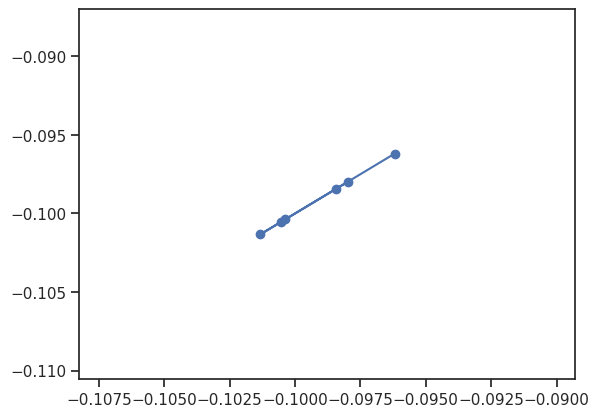

In [46]:
plt.scatter(E2Dict,stacked_e2.sum())
plt.plot(E2Dict.values,E2Dict.values)

In [47]:
# big_40=stacked_e2.T.abs().describe().loc['mean'].sort_values(ascending=False).nlargest(500).index


In [48]:
stacked_pairs=pd.concat([typA_e2,typB_e2,typC_e2,typD_e2,typE_e2,typF_e2,typG_e2,typH_e2]).groupby(level=0).sum()
pair_labels=stacked_pairs.index.tolist()

In [49]:
typ_exists

['A', 'B_P', 'C', 'D', 'E_M', 'E_P', 'F_M', 'F_P', 'G_M', 'G_P', 'H_M', 'H_P']

In [50]:
dummy_stack=pd.concat([gen_e2(typ) for typ in typ_exists])

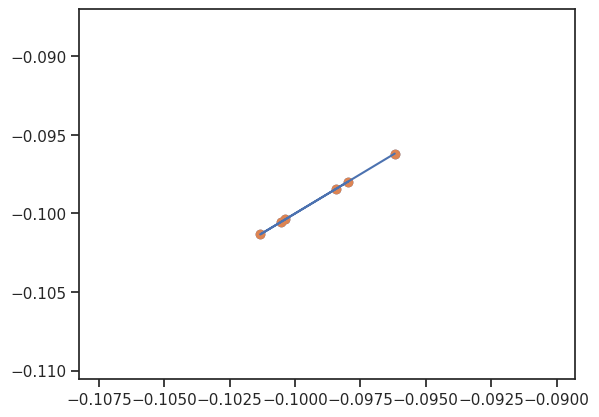

In [51]:
plt.scatter(E2Dict,dummy_stack.sum())
plt.scatter(dummy_stack.sum(),stacked_e2.sum())
plt.plot(E2Dict.values,E2Dict.values)

In [52]:
# Grab molecular orbital occupations and make it into a dataframe labeled with xyz file name
MO_OCC=[]
for j in range(len(structs)):
    MO_OCC.append(dict(zip(Basis_Indices,[i for i in list(MO_OCCUPATIONS[j])])))
MO_OCC_Dict=dict(zip([str(k) for k in structs],MO_OCC))
MO_OCC_DF=pd.DataFrame(MO_OCC_Dict)

# Dataframe of MO occupation, index=basis indices and columns=structs
MO_OCCUPATIONS_DF=pd.DataFrame(MO_OCCUPATIONS,index=structs,columns=Basis_Indices).transpose()



In [53]:
# 
# Keep in mind HDF5 zeroes out the actrive orbitals... we'll use the Fock matrix to recover these
# 
# Grab molecular orbital energy and make it into a dataframe labeled with xyz file name
MO_ENERGIES=[]
for j in structs:
    MO_ENERGIES.append(np.genfromtxt(os.path.join(path_to_Focks,f'{j}.GMJ_Fock_MO.csv'), delimiter=''))


# Dataframe of MO energies, index=basis indices and columns=structs
MO_ENERGIES_DF=pd.DataFrame(MO_ENERGIES,index=structs,columns=Basis_Indices).transpose()


In [54]:
Basis_Indices

['I1',
 'I2',
 'I3',
 'I4',
 'I5',
 'I6',
 'I7',
 'I8',
 'I9',
 'I10',
 'A1',
 'A2',
 'A3',
 'S1',
 'S2']

In [55]:
len(Basis_Indices)

15

In [56]:
def gen_one_int():
    one_int=[]
    Labels=[]
    Indexes=[]
    upd_1int_indx=[]
    def one_gener(i):
        return pd.DataFrame(np.genfromtxt(os.path.join(path_to_1_ints,f'{i}.GMJ_one_int.csv'), delimiter='',dtype=float),index=Basis_Indices,columns=Basis_Indices)
            

#     Dict=dict(zip(Indexes,Labels))
    return dict((i,one_gener(i)) for i in structs)





In [57]:
t0=time()
int1=gen_one_int()
print(f'Integrals loaded in {time()-t0:0.4f} s')

Integrals loaded in 0.0117 s


In [58]:
# pd.set_option("precision", 2)
# np.set_printoptions(precision=2)
# pd.options.display.float_format = '{:,.2f}'.format



nmo=len(Basis_Indices)
indice=[]
ad_ind=[]
for ind,i in enumerate(range(nmo)):
    for indx,j in enumerate(range(nmo)):
        ad_ind.append(f'{i+1}_{j+1}')
        if j<=i:
            indice.append(f'{i+1}_{j+1}')

In [59]:
len(indice),len(ad_ind)

(120, 225)

In [60]:

# raw_MO=pd.DataFrame(np.genfromtxt(os.path.join(path_to_2_ints,f'{structs[0]}.GMJ_two_int.csv'), delimiter='',dtype=float),index=indice,columns=indice)

# # This is wrong
# for ind,a in enumerate(indice):
#     for indx,b in enumerate(indice):
#         if a!=b:
#             print(a.split('_'),b.split('_'))
#             # print(f'{j+1}_{i+1}',raw_MO[f'{j+1}_{i+1}'])
#             # raw_MO.loc[f'{j+1}_{i+1}']=AO_DF.loc[f'{i+1}_{j+1}']

In [61]:
import itertools

def gen_MO(k):
    if os.path.exists(os.path.join(path_to_2_ints,f'{k}.GMJ_two_int.csv'))==True:

        raw_MO=np.genfromtxt(os.path.join(path_to_2_ints,f'{k}.GMJ_two_int.csv')).reshape(len(Basis_Indices),len(Basis_Indices),len(Basis_Indices),len(Basis_Indices))
    return raw_MO

In [62]:
# featurelist=list()
# def GenerateFeatures(wf_object, Miller=False, values=4):
#     b =   wf_object.triplecheck

#     #c = np.log10(np.absolute(wf_object.get_MO('oovv')*wf_object.t2start))
#     ##infcheck=(c == -np.inf)
#     #c[infcheck]=20

#     #d = wf_object.pairs

#     if Miller == False:
#         for i in range(b.shape[0]):
#             for j in range (b.shape[1]):
#                 print('Top',i,j)
#                 featurelist.clear()
# # sort MP2 two-electron excitations e_{ij}^{ab} for ij
# # (most negative, …, smallest negative, …, smallest positive, …, largest positive)
# # [:values]=first x values        
# # [-values:]=last x values
#                 ind=np.argsort(b[i,j].flatten(),axis=0)
# # εij{MP2}
#                 new=np.sum(b[i,j])#0
# #                 featurelist.append('Pair_Energy')
# # <ii||jj>        
#                 new=np.hstack((new,wf_object.MO[i,i,j,j]))
# # screen1 first 4 values (i) <ii||aa>
#                 new=np.hstack((new,np.take_along_axis(wf_object.screen1[i,j].flatten(), ind, axis=0)[:values]))#1,2,3,4
# # screen2 first 4 values (j) <jj||bb>
#                 new=np.hstack((new,np.take_along_axis(wf_object.screen2[i,j].flatten(), ind, axis=0)[:values]))#9,10,11,12
# # <aa||bb> matrix first 4 values 
#                 new=np.hstack((new,np.take_along_axis(wf_object.screenvirt[i,j].flatten(), ind, axis=0)[:values]))#9,10,11,12
# # e_{ij}^{ab}{MP2} first 4 values
#                 new=np.hstack((new,np.take_along_axis(b[i,j].flatten(), ind, axis=0)[:values]))#17,18,19,20
#                 if i==j:       
# # <ii||jj> is excluded since i==j                
#                     ind=np.argsort(b[i,j].flatten(),axis=0)
# # εij{MP2}                    
#                     new=np.sum(b[i,j])#0
# # screen1 first 4 values (i)
#                     new=np.hstack((new,np.take_along_axis(wf_object.screen1[i,j].flatten(), ind, axis=0)[:values]))#1,2,3,4
# # screen2 first 4 values (j)       
#                     new=np.hstack((new,np.take_along_axis(wf_object.screen2[i,j].flatten(), ind, axis=0)[:values]))#9,10,11,12
# # screen1 last 4 values (i)
#                     new=np.hstack((new,np.take_along_axis(wf_object.screen1[i,j].flatten(), ind, axis=0)[-values:]))#1,2,3,4
# # screen2 last 4 values (j)
#                     new=np.hstack((new,np.take_along_axis(wf_object.screen2[i,j].flatten(), ind, axis=0)[-values:]))#9,10,11,12

# # e_{ij}^{ab}{MP2} first 4 values                    
#                     new=np.hstack((new,np.take_along_axis(b[i,j].flatten(), ind, axis=0)[:values]))#17,18,19,20
# # e_{ij}^{ab}{MP2} last 4 values    
#                     new=np.hstack((new,np.take_along_axis(b[i,j].flatten(), ind, axis=0)[-values:]))#17,18,19,20
# # Missing εij{MP2} correlation in representation                    
#                     one=np.sum(np.take_along_axis(b[i,j].flatten(), ind, axis=0)[-values:])
#                     two=np.sum(np.take_along_axis(b[i,j].flatten(), ind, axis=0)[:values])
#                     new=np.hstack((new, np.sum(b[i,j])-one-two))
#                     featurelist.append('triplecheck1')
#                 else:
# # i!=j                    
#                     ind=np.argsort(b[i,j].flatten(),axis=0)
# # εij{MP2}    
#                     new=np.sum(b[i,j])#0      
# # <ii||jj>                    
#                     new=np.hstack((new,wf_object.MO[i,i,j,j]))
# # screen1 first 4 values (i)
#                     new=np.hstack((new,np.take_along_axis(wf_object.screen1[i,j].flatten(), ind, axis=0)[:values]))#1,2,3,4
# # screen2 first 4 values (j)                    
#                     new=np.hstack((new,np.take_along_axis(wf_object.screen2[i,j].flatten(), ind, axis=0)[:values]))#9,10,11,12
# # screen1 last 4 values (i)
#                     new=np.hstack((new,np.take_along_axis(wf_object.screen1[i,j].flatten(), ind, axis=0)[-values:]))#1,2,3,4
# # screen2 last 4 values (j)                    
#                     new=np.hstack((new,np.take_along_axis(wf_object.screen2[i,j].flatten(), ind, axis=0)[-values:]))#9,10,11,12
# # e_{ij}^{ab}{MP2} first 4 values                                        
#                     new=np.hstack((new,np.take_along_axis(b[i,j].flatten(), ind, axis=0)[:values]))#17,18,19,20
# # e_{ij}^{ab}{MP2} last 4 values    
#                     new=np.hstack((new,np.take_along_axis(b[i,j].flatten(), ind, axis=0)[-values:]))#17,18,19,20                    
# # Missing εij{MP2} correlation in representation                    
#                     one=np.sum(np.take_along_axis(b[i,j].flatten(), ind, axis=0)[-values:])
#                     two=np.sum(np.take_along_axis(b[i,j].flatten(), ind, axis=0)[:values])
#                     new=np.hstack((new, np.sum(b[i,j])-one-two))


#                 if ((i==0) and (j==0)):
#                     a=new.copy()
#                     diag=wf_object.pairs[i,j]
#                 elif ((i==0) and (j==1)):
#                     g=new.copy()
#                     offdiag=wf_object.pairs[i,j]
#                 elif (i==j):        
#                     a=np.vstack((a,new))#41
#                     diag=np.vstack((diag,wf_object.pairs[i,j]))
#                 elif (j > i):
#                     g=np.vstack((g,new))#41
#                     offdiag=np.vstack((offdiag,wf_object.pairs[i,j]))
#         return a,diag,g,offdiag

In [63]:

froz=[indx for indx,i in enumerate(Basis_Indices) if i.startswith('F')]
inact=[indx for indx,i in enumerate(Basis_Indices) if i.startswith('I')]
act=[indx for indx,i in enumerate(Basis_Indices) if i.startswith('A')]
virt=[indx for indx,i in enumerate(Basis_Indices) if i.startswith('S')]


In [64]:
# gen_F=dict(zip(structs,scf_F))
# gen_occ=dict(zip(structs,scf_OCC))

gen_F=MO_ENERGIES_DF
gen_occ=MO_OCCUPATIONS_DF
gen_F_SCF=pd.DataFrame(scf_F,columns=Basis_Indices,index=structs).T
gen_occ_SCF=pd.DataFrame(scf_OCC,columns=Basis_Indices,index=structs).T

In [65]:
Basis_Indices

['I1',
 'I2',
 'I3',
 'I4',
 'I5',
 'I6',
 'I7',
 'I8',
 'I9',
 'I10',
 'A1',
 'A2',
 'A3',
 'S1',
 'S2']

In [66]:

full_set=sorted(set(sum([gen_pair_labels(typ) for typ in typ_exists],[])))

In [67]:
# Rewrite the jacob style featurization step
occcc=len(MO_OCC_DF.T.describe().loc['mean'][MO_OCC_DF.T.describe().loc['mean']!=0])
virttt=len(MO_OCC_DF.T.describe().loc['mean'][MO_OCC_DF.T.describe().loc['mean']!=2])




In [73]:
class gen_big_4(object):
    '''
    Generate a set of i,j,k,l indices corresponding to the largest 4 two-electron excitations 
    per pair-energy.

    !!!From here on out we need to use the same training set and test set.!!!
    Indices:
    i-internal
    j-internal
    k-external
    l-external

    '''    
    # Pick 4 largest contributers to the pair energy
    def big_4(self,dist):
        return [['_'.join(k.split('_')[2:4]) for k in dummy_stack.loc[[ j for j in dummy_stack.index.tolist() if j.split('_')[0]==i.split('_')[0] and j.split('_')[1]==i.split('_')[1]]][dist].abs().sort_values(ascending=False).index[0:4].tolist()] for i in stacked_pairs.index.tolist()]
    
    def gen_ijkl(self):
        # Dimensions: training index x pair energies x top 4 most frequent virtual orbitals for two electrion excitations
        self.train_4=np.array([self.big_4(i) for i in train_ind])
        print(self.train_4.shape)
        # Most frequent: list of tuples containing (pair energy index, [top 4 most frequent virtual orbitals for two electrion excitations])
        # This can serve as a label too.
        self.train_freq=[(i,pd.DataFrame(self.train_4[:,idx,:]).describe().loc['top'].tolist()) for idx,i in enumerate(stacked_pairs.index.tolist())]
        # i,j, set of 4 largest [(k,l)]
        self.set_ijkl_indices=[(Basis_Indices.index(i.split('_')[0]),Basis_Indices.index(i.split('_')[1]),[(Basis_Indices.index(k.split('_')[0]),Basis_Indices.index(k.split('_')[1])) for k in pd.DataFrame(self.train_4[:,idx,:]).describe().loc['top'].tolist()]) for idx,i in enumerate(stacked_pairs.index.tolist())]
        internal_basis=[i for i in Basis_Indices if 'S' not in i]
        external_basis=[i for i in Basis_Indices if 'I' not in i]
        print(external_basis)
    # This is 1 indices per pair energy!        
        set_i_indices=[]
    # This is 1 indices per pair energy!            
        set_j_indices=[]
    # This is a set of 4 indices per pair energy!    
        set_k_indices=[]
    # This is a set of 4 indices per pair energy!    
        set_l_indices=[]
        for idx,i in enumerate(stacked_pairs.index.tolist()):
            set_i_indices.append(internal_basis.index(i.split('_')[0]))
            set_j_indices.append(internal_basis.index(i.split('_')[1]))
            set_k_indices.append([external_basis.index(k.split('_')[0]) for k in pd.DataFrame(self.train_4[:,idx,:]).describe().loc['top'].tolist()])
            set_l_indices.append([external_basis.index(k.split('_')[1]) for k in pd.DataFrame(self.train_4[:,idx,:]).describe().loc['top'].tolist()])
            
        return set_i_indices,set_j_indices,set_k_indices,set_l_indices,self.train_freq

In [74]:
ijkl_idx=gen_big_4().gen_ijkl()
set_i_indices=ijkl_idx[0]
set_j_indices=ijkl_idx[1]
set_k_indices=ijkl_idx[2]
set_l_indices=ijkl_idx[3]
set_indices=ijkl_idx[4]

(4, 94, 4)
['A1', 'A2', 'A3', 'S1', 'S2']


In [75]:
set_indices

[('A1_A1', ['S1_S1', 'S2_S2', 'S2_S1', 'S2_A1']),
 ('A1_A2', ['S2_A2', 'S1_A1', 'S1_A2', 'S1_A2']),
 ('A1_A3', ['S1_A3', 'S1_A2', 'S1_A2', 'S1_A2']),
 ('A2_A1', ['S2_S1', 'S2_S1', 'S2_S1', 'S2_S1']),
 ('A2_A2', ['S1_S1', 'S2_S2', 'S2_S1', 'S1_A3']),
 ('A2_A3', ['S1_A2', 'S2_A2', 'S2_A3', 'S1_A3']),
 ('A3_A1', ['S1_S1', 'S2_S2', 'S2_S1', 'S2_S1']),
 ('A3_A2', ['S2_S1', 'S2_S1', 'S2_S1', 'S2_S1']),
 ('A3_A3', ['S1_S1', 'S2_S2', 'S2_S1', 'S1_A2']),
 ('I10_A1', ['A3_S1', 'A2_S2', 'A1_S1', 'S1_A1']),
 ('I10_A2', ['A3_S2', 'A2_S1', 'A1_S2', 'S2_A3']),
 ('I10_A3', ['A2_S2', 'A1_S1', 'A3_S1', 'S2_A2']),
 ('I10_I1', ['A3_A3', 'A3_A1', 'A1_A1', 'A2_A2']),
 ('I10_I10', ['S2_S2', 'A3_A3', 'A2_A2', 'A1_A1']),
 ('I10_I2', ['S2_S1', 'S2_S1', 'A3_A3', 'A2_A2']),
 ('I10_I3', ['A3_A3', 'A2_A2', 'A3_A1', 'A1_A1']),
 ('I10_I4', ['A3_A3', 'A3_A1', 'A1_A1', 'A2_A2']),
 ('I10_I5', ['S1_S1', 'S2_S1', 'S2_S1', 'S2_S2']),
 ('I10_I6', ['A3_A3', 'A3_A1', 'A3_A1', 'A1_A1']),
 ('I10_I7', ['A2_A2', 'A3_A1', 'A3_A3',

In [76]:



occcc=len(MO_OCC_DF.T.describe().loc['mean'][MO_OCC_DF.T.describe().loc['mean']!=0])
virttt=len(MO_OCC_DF.T.describe().loc['mean'][MO_OCC_DF.T.describe().loc['mean']!=2])





In [77]:
# Create slices for AA->AA indices
# This will help zero out infinities
internal_A=[idx for idx,i in enumerate(MO_OCC_DF.T.describe().loc['mean'][MO_OCC_DF.T.describe().loc['mean']!=0].index) if 'A' in i]
external_A=[idx for idx,i in enumerate(MO_OCC_DF.T.describe().loc['mean'][MO_OCC_DF.T.describe().loc['mean']!=2].index) if 'A' in i]

inner_slice=slice(min(internal_A),max(internal_A)+1)
outer_slice=slice(min(external_A),max(external_A)+1)

In [78]:

class gen_two_ints(object):
# Some of the D_{ij}^{ab}=f_{ii}+f_{jj}-f_{aa}-f_{bb}=e_{ii}+e_{jj}-e_{aa}-e_{bb} elements 
# will be 0 since ij and ab overlap for CASPT2
# ij \in {I,A}
# ab \in {A,V}
# So ignore the warnings since they'll only be 0 when ijab \in {A} only
    import warnings
    warnings.simplefilter('ignore')
    
    def get_MO(self, string):
        return self.MO[self.slice_dict[string[0]], self.slice_dict[string[1]],self.slice_dict[string[2]], self.slice_dict[string[3]]]

    def get_F(self, string):
        return self.F[self.slice_dict[string[0]], self.slice_dict[string[1]]] 
    
    def compute_pairmatrix(self,selft2start,selfdoublecheck):
        test = 2*selft2start*selfdoublecheck
        test -= np.swapaxes(selft2start,2,3)*selft2start
        c=np.sum(test,axis=(2,3))
        return c    
    
    def build_tau(self,t2,t1):
        ttau = t2.copy()
        tmp = np.einsum('ia,jb->ijab', t1, t1,optimize=True)
        ttau += tmp
        return ttau    
    
#     def __init__(self,k):
    def gen_feat(self,k):
# Set variables
# nocc:=Occupied orbitals
# nvirt:=virtual orbitals
# nfzc:=frozen orbitals
# nmo:=number of orbitals
        nocc=occcc
        nvirt=virttt
        self.nfzc=len(froz)
        self.nocc=nocc
        self.nvirt=nvirt
        self.nmo=len(Basis_Indices)
        nmo=nocc+nvirt
# nmo=nocc+nvirt
# Set slices
# In CASPT2 occupied run I-A and virtual run A-S
# Unlike MP2 there will be overlap between internal and external indices
        self.slice_o = slice(0,nocc)
        self.slice_v = slice(len(Basis_Indices)-virttt,len(Basis_Indices))
        self.slice_a = slice(0,nmo)    

# Dictionary with the slices        

        self.slice_dict = {
            'o': self.slice_o,
            'v': self.slice_v,
            'a': self.slice_a
        }
        
        
        

        featurelist=list()    
# Virtual
        self.empty=np.zeros((nvirt,))
# Occupied    
        self.occupado=np.zeros((nocc,))
# MO integrals    
        self.MO=gen_MO(k)
# MO Fock matrix    
        self.F=gen_F[k].to_numpy()
# Zero out t1 matrix, dim(occ,virt)    
        self.t1=np.zeros((nocc,nvirt))
# MO Fock matrix internal
        Focc = self.F[self.slice_o]
# MO Fock matrix external    
        Fvir = self.F[self.slice_v]  
        self.orbocc=Focc
        self.orbvirt=Fvir

        self.Dia = Focc.reshape(-1, 1) - Fvir
        self.Dijab = Focc.reshape(-1, 1, 1, 1) + Focc.reshape(-1, 1, 1) - Fvir.reshape(-1, 1) - Fvir 

        
# Clean up AA block to get rid of infinities, we do not need this anyway              
# t2=<ij||ab>/(e_i+e_j-e_a-e_b)
# But this is <ij|ab>... idk...
        self.t2start=self.MO[self.slice_o, self.slice_o, self.slice_v,self.slice_v] / self.Dijab
# Zero out AA->AA
        self.t2start[inner_slice,inner_slice,outer_slice,outer_slice]=0

# Related to the correlation energy
# np.einsum('ijab->',triplecheck)=MP2 correlation energy in jacob's code
#dim(triplecheck)=(occ,occ,virt,virt)
        self.triplecheck=2*self.t2start*self.get_MO('oovv')
        self.triplecheck -=  np.swapaxes(self.get_MO('oovv'),2,3)*self.t2start 
# Zero out AA->AA
        self.triplecheck[inner_slice,inner_slice,outer_slice,outer_slice]=0

        
        
# Integral
# doublecheck =<ij|ab>
#dim(doublecheck)=(occ,occ,virt,virt)
        self.doublecheck = self.MO[self.slice_o, self.slice_o, self.slice_v, self.slice_v]   
# Zero out AA->AA
        self.doublecheck[inner_slice,inner_slice,outer_slice,outer_slice]=0


    
# Not related to the correlation energy?
# dim(pairenergy)=(occ,occ,virt,virt)
# dim(compute_pairmatrix(t2start,doublecheck))=(occ,occ)->(occ,occ,virt,virt)
        self.pairenergy=(np.zeros(self.doublecheck.shape)+self.compute_pairmatrix(self.t2start,self.doublecheck)[:,:,np.newaxis,np.newaxis])
# Zero out AA->AA
        self.pairenergy[inner_slice,inner_slice,outer_slice,outer_slice]=0


# Related to the correlation energy
#dim(pairs)=(virt,virt)
# np.einsum('ab->',pairs)=np.einsum('ijab->',triplecheck)=MP2 correlation energy in jacob's code
        tmp_tau = self.build_tau(self.t2start,self.t1)
        self.pairs=2*tmp_tau*self.get_MO('oovv')
        self.pairs-= np.swapaxes(self.get_MO('oovv'),2,3)*tmp_tau
        self.pairs = np.sum(self.pairs,axis=(2,3))
# Zero out AA->AA
        self.pairs[inner_slice,outer_slice]=0        




        test=np.zeros(self.t2start.shape)
        self.diag=test
        for i in range (0,self.nocc):
            for j in range (0,self.nocc):
                np.fill_diagonal(self.diag[i,j,:,:],1)

# Dim(temp)=(occ,virt)
# Basically dim(<ii|jj>)->dim(<i|j>)
        temp=np.zeros((self.nocc,self.nvirt))
        for i in range (0,self.nocc):
            for j in range (0,self.nvirt):
                temp[i,j]=self.doublecheck[i,i,j,j]
# Dim(test1)=(occ,occ,virt,virt)                
        test1=np.zeros((self.t2start.shape))

# dim(temp)=(occ,virt) -> dim(temp[:,np.newaxis,:,np.newaxis])=(occ,1,virt,1)
# np.newaxis makes this a dummy index, : will be unique
# i.e. (occ,copy,virt,copy)
# (occ,occ,virt,virt) + (occ,1,virt,1)
# <ii||aa>    
        self.screen1=test1+temp[:,np.newaxis,:,np.newaxis]
# Zero out AA->AA
        self.screen1[inner_slice,inner_slice,outer_slice,outer_slice]=0            

# dim(temp)=(occ,virt) -> dim(temp[np.newaxis,:,np.newaxis,:])=(1,occ,1,virt)
# (occ,occ,virt,virt) + (1,occ,1,virt)
# np.newaxis makes this a dummy index, : will be unique
# i.e. (copy,occ,copy,virt)
# <jj||bb>    
        self.screen2=test1+temp[np.newaxis,:,np.newaxis,:]
# Zero out AA->AA
        self.screen2[inner_slice,inner_slice,outer_slice,outer_slice]=0                
# screen1[i,j,k,l]==screen2[j,i,l,k].T

# nfzc=# frozen core
        val=self.nmo-self.nfzc
# Dim(temp)=(nmo,nmo)
# Basically dim(<ii|jj>)->dim(<i|j>)    
        temp=np.zeros((val,val))        
        for i in range (0,val):
            for j in range (0,val):
                temp[i,j]=self.MO[i,i,j,j]
# Get virtual indices: <aa|bb> basically
# <aa||bb>
# (occ,occ,virt,virt) + (virt,virt)
# (occ,occ,virt,virt) + (1,1,virt,virt)                
        temp =temp[self.slice_v,self.slice_v]
        self.screenvirt=test1+temp[np.newaxis,np.newaxis,:,:]
# Zero out AA->AA
        self.screenvirt[inner_slice,inner_slice,outer_slice,outer_slice]=0
        # b=(i,j,a,b)=(13, 13, 5, 5)
        b=self.triplecheck
# Zero out AA->AA
        diag_indx=[]
        off_diag_indx=[]     
        featurelist=[]
        featurelist.clear()
        feature=[]
        feature.clear()    
        index=['pair_energy','coulomb','screen1_1','screen1_2','screen1_3','screen1_4','screen2_1','screen2_2','screen2_3','screen2_4','eijab_1','eijab_2','eijab_3','eijab_4','screenvirt_1','screenvirt_2','screenvirt_3','screenvirt_4']        
        for idx,i in enumerate([j for j,v in set_indices]):
# εij{MP2}              
            new=np.sum(b[set_i_indices[idx],set_j_indices[idx]])#0
# <ii||jj>    
            new=np.hstack((new,self.MO[set_i_indices[idx],set_i_indices[idx],set_j_indices[idx],set_j_indices[idx]]))
# <ii||aa>    
            new=np.hstack((new,np.array([self.screen1[set_i_indices[idx],set_j_indices[idx],k,l] for k,l in zip(set_k_indices[idx],set_l_indices[idx])]).flatten()))
# <jj||bb>    
            new=np.hstack((new,np.array([self.screen2[set_i_indices[idx],set_j_indices[idx],k,l] for k,l in zip(set_k_indices[idx],set_l_indices[idx])]).flatten()))
# e_{ij}^{ab} MP2
            new=np.hstack((new,np.array([b[set_i_indices[idx],set_j_indices[idx],k,l] for k,l in zip(set_k_indices[idx],set_l_indices[idx])]).flatten()))
# # <aa||bb>    
            new=np.hstack((new,np.array([self.screenvirt[set_i_indices[idx],set_j_indices[idx],k,l] for k,l in zip(set_k_indices[idx],set_l_indices[idx])]).flatten()))
            featurelist.append((i,new))
        return pd.DataFrame(dict(featurelist),index=index).T
#         return pd.concat([pd.DataFrame(self.a,index=diag_indx),pd.DataFrame(self.g,index=off_diag_indx)]).loc[full_set]

# gen_feat
#     self.dict=dict([(k,gen_feat(k))for k in structs])





In [79]:
def elements(x):
    '''
    Takes an integer, x, and returns the number of off-diagonal elements of an upper triangular matrix
    f(x)=(x*(x-1))/2
    '''
    return (x*(x-1))/2

In [85]:
stacked_pairs.index,dummy_stack.index

(Index(['A1_A1', 'A1_A2', 'A1_A3', 'A2_A1', 'A2_A2', 'A2_A3', 'A3_A1', 'A3_A2',
        'A3_A3', 'I10_A1', 'I10_A2', 'I10_A3', 'I10_I1', 'I10_I10', 'I10_I2',
        'I10_I3', 'I10_I4', 'I10_I5', 'I10_I6', 'I10_I7', 'I10_I8', 'I10_I9',
        'I1_A1', 'I1_A2', 'I1_A3', 'I1_I1', 'I2_A1', 'I2_A2', 'I2_A3', 'I2_I1',
        'I2_I2', 'I3_A1', 'I3_A2', 'I3_A3', 'I3_I1', 'I3_I2', 'I3_I3', 'I4_A1',
        'I4_A2', 'I4_A3', 'I4_I1', 'I4_I2', 'I4_I3', 'I4_I4', 'I5_A1', 'I5_A2',
        'I5_A3', 'I5_I1', 'I5_I2', 'I5_I3', 'I5_I4', 'I5_I5', 'I6_A1', 'I6_A2',
        'I6_A3', 'I6_I1', 'I6_I2', 'I6_I3', 'I6_I4', 'I6_I5', 'I6_I6', 'I7_A1',
        'I7_A2', 'I7_A3', 'I7_I1', 'I7_I2', 'I7_I3', 'I7_I4', 'I7_I5', 'I7_I6',
        'I7_I7', 'I8_A1', 'I8_A2', 'I8_A3', 'I8_I1', 'I8_I2', 'I8_I3', 'I8_I4',
        'I8_I5', 'I8_I6', 'I8_I7', 'I8_I8', 'I9_A1', 'I9_A2', 'I9_A3', 'I9_I1',
        'I9_I2', 'I9_I3', 'I9_I4', 'I9_I5', 'I9_I6', 'I9_I7', 'I9_I8', 'I9_I9'],
       dtype='object'),
 Index(['I1_A1_A1_A

In [81]:
def gen_1_feats(k):
    # t0=time()
    # For an e_pq, there should be 10 F, 10 occs, and then 10 SCF F and 10 SCF occs
    Fp=[]
    Fq=[]

    occp=[]
    occq=[]

    SCFFp=[]
    SCFFq=[]


    SCFOCCp=[]
    SCFOCCq=[]

    hpp=[]
    hqq=[]
    hrr=[]
    hss=[]

    rs_df=[]
    h=int1[k]
    for idx,i in enumerate(set_indices):

        p,q=i[0].split('_')
        # print(p,q)
        Fp.append(gen_F.loc[p,k])
        Fq.append(gen_F.loc[q,k])
        occp.append(gen_occ.loc[p,k])
        occq.append(gen_occ.loc[q,k])

        SCFFp.append(gen_F_SCF.loc[p,k])
        SCFFq.append(gen_F_SCF.loc[q,k])
        SCFOCCp.append(gen_occ_SCF.loc[p,k])
        SCFOCCq.append(gen_occ_SCF.loc[q,k])
        hpp.append(h.loc[p,p])
        hqq.append(h.loc[p,p])



        Fr=[]
        Fs=[]
        occr=[]
        occs=[]
        SCFFr=[]
        SCFFs=[]
        SCFOCCr=[]
        SCFOCCs=[]
        for idxx,j in enumerate(i[1]):
            r,s=j.split('_')

            Fr.append((f'Fr{idxx+1}',gen_F.loc[r,k]))
            Fs.append((f'Fs{idxx+1}',gen_F.loc[s,k]))

            occr.append((f'occr{idxx+1}',gen_occ.loc[r,k]))
            occs.append((f'occs{idxx+1}',gen_occ.loc[s,k]))

            SCFFr.append((f'SCFFr{idxx+1}',gen_F_SCF.loc[r,k]))
            SCFFs.append((f'SCFFs{idxx+1}',gen_F_SCF.loc[s,k]))


            SCFOCCr.append((f'SCFOCCr{idxx+1}',gen_occ_SCF.loc[r,k]))
            SCFOCCs.append((f'SCFOCCs{idxx+1}',gen_occ_SCF.loc[s,k]))

            hrr.append((f'hrr{idxx+1}',h.loc[r,r]))
            hss.append((f'hss{idxx+1}',h.loc[s,s]))


        rs_df.append(pd.DataFrame.from_dict({**dict(Fr),**dict(Fs),**dict(occr),**dict(occs),**dict(SCFFr),**dict(SCFFs),**dict(SCFOCCr),**dict(SCFOCCs),**dict(hrr),**dict(hss)},orient='index',columns=[i[0]]))
    rs=pd.concat(rs_df,axis=1).T
    dummy_df=pd.DataFrame({'hpp':hpp,'hqq':hqq,'Fp':Fp,'Fq':Fq,'occp':occp,'occq':occq,'SCFFp':SCFFp,'SCFFq':SCFFq,'SCFOCCp':SCFOCCp,'SCFOCCq':SCFOCCq},index=pair_labels)
    # print(f'{k} {time()-t0}')
    return pd.concat([rs,dummy_df],axis=1)

In [82]:

def gen_two_el():
    return dict([(k,gen_two_ints().gen_feat(k))for k in structs])


def gen_one_diag():
    return dict([(k,gen_1_feats(k)) for k in structs])


def gen_bin():
    # FSO=From same orbital
    FSO=[]
    # Indexing
    featind=[]
    # Keys=Structs in string format
    keys=[]
    for i in structs:
        k=str(i)
        keys.append(k)
        for ind,g in enumerate(full_set):
# Epq Ers
# # e_q+e_s-e_p-e_r
# TIUV
#'A'+g[0]+'_I'+g[1]+''+g[2]+''+g[3]
# Eti Euv (E01 E23)
# e_i+e_v-e_u-e_t
# e[0] + e[3] - e[1] - e[2]
            featind.append(g)
            idx=g.split('_')
            q=idx[0]
            s=idx[1]
# Since I!=A just append 0 since they'll never both come from the same orbital                
            if q==s:
                FSO.append(1)
            else:
                FSO.append(0)
    return dict([(z,pd.DataFrame({'From_Same_Orbital':np.array(FSO).reshape(len(structs),-1)[idx]},index=np.array(featind).reshape(len(structs),-1)[idx])) for idx,z in enumerate(keys)])               




In [83]:

def Big_Data_GS():
    t0=time()
    with open('fixed_feats.pickle', 'wb') as handle:
        pickle.dump(pd.concat([pd.concat({k: v for k,v in gen_bin().items()},axis=0),
                               pd.concat({k: v for k,v in gen_two_el().items()},axis=0),
                               pd.concat({k: v for k,v in gen_one_diag().items()},axis=0)],axis=1), handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open('fixed_targets.pickle', 'wb') as handle:
        pickle.dump(stacked_pairs, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print(time()-t0)


In [84]:
Big_Data_GS()


0.5704541206359863


In [ ]:
# pd.read_pickle(f'fixed_feats.pickle'),
# pd.read_pickle(f'typH_targets.pickle').plot()